# Importierung

Für die bessere Überischt importieren wir alles an einem Ort. Wir verwenden hier Keras V3. Damit wird ermöglicht, dass wir Backend-Agnostic arbeiten können. Das bedeutet, dass wir das Backend (Tensorflow, Pytorch, Jax) einfach wechseln können.
Wir verwenden hier Pytorch als Backend, da es nativen GPU Support auf Windows hat. Ohne GPU geht das Training viel zu lange.

In [10]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from livelossplot import PlotLossesKeras
from matplotlib import pyplot as plt
import keras_tuner


IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64
AUGMENT = True

# Bild-Datensatz laden

Mit der Funktion `image_dataset_from_directory` können wir die Bilddaten von der Festplatte laden. Dabei müssen sie in einem bestimmten Format sein. Ein Ordner mit jeweils einem Unterordner für jede Klasse. Hier werden auch direkt die Batches erstellt, die Bilder auf eine gemeinsame Grösse "gepadded" und ein Validation/Train Split erstellt. Die Labels sind für zwei Klassen Binär (0 oder 1) und bei mehreren Klassen als One-Hot-Encoded Vektor gespeichert.

In [11]:
_data_dir = os.path.join("data", "images")
_entries = os.listdir(_data_dir)
_folder_count = sum(os.path.isdir(os.path.join(_data_dir, entry)) for entry in _entries)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
        os.path.join("data", "images"),
        labels="inferred",
        label_mode="binary" if _folder_count == 2 else "categorical",
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        interpolation="bilinear",
        pad_to_aspect_ratio=True,
        validation_split=0.2,
        subset="both",
        seed=42,
    )

for _, _labels in train_ds.take(1):
    print(_labels)
    break

if len(train_ds.class_names) == 2:
    NUMBER_OF_CLASSES = 1
else:
    NUMBER_OF_CLASSES = len(train_ds.class_names)

Found 24000 files belonging to 2 classes.
Using 19200 files for training.
Using 4800 files for validation.
tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]], shape=(64, 1), dtype=float32)


# Data Augmentation

Data Augmentation hilft dabei helfen die Klassifikation besser zu machen, indem die Daten variiert werden. Damit sollte das Modell weniger von Overfitting betroffen sein. Wir drehen sie, verändern den Kontrast und die Helligkeit. Zusätzlich werden die Daten auf einen Wert zwischen 0 und 1 normalisiert, indem sie durch 255 geteilt werden.

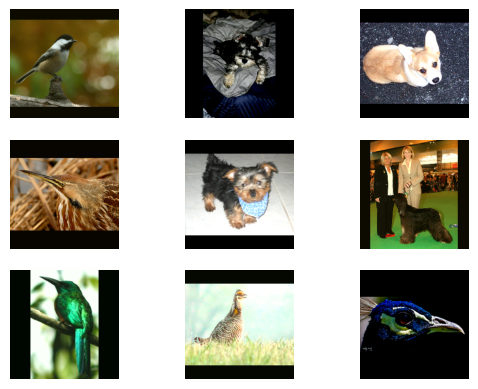

<Figure size 2000x2000 with 0 Axes>

In [13]:
data_augmentation_layers = [
    # layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(0.1, fill_mode="constant", interpolation="bilinear"),
    layers.RandomContrast(0.4),
    layers.RandomBrightness(0.4),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

if AUGMENT:
    train_ds = train_ds.map(
        lambda images, labels: (data_augmentation(images), labels))
    
    val_ds = val_ds.map(
        lambda images, labels: (data_augmentation(images), labels))

for batch_images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.array_to_img(batch_images[i]))
        plt.axis("off")
plt.figure(figsize=(20, 20))
plt.show()

# CNN-Modell erstellen

Dann bauen wir ein CNN. Der Kern sind 4 Gruppen an Layers, welche jeweils eine Convolution, Batch-Normalisierung, Max-Pooling und Dropout beinhalten. Dabei vergrössert sich die Filter-Grösse in jedem Schritt. Dadurch erhoffen wir uns zuerst kleinere Features zu finden und dann grössere Zusammenhänge in den Bildern abzudecken.

Als Metriken verwenden wir die Precision, Recall, F1-Score und Accuracy. Die Loss-Funktion ist je nach Anzahl Klassen entweder BinaryCrossentropy oder CategoricalCrossentropy. Den Loss Berechnen wir jeweils direkt von den Logits. Es gab Probleme, wenn wir zuerst ein Klassifikationslayer verwendeten. Als Optimizer verwenden wir AdamW.

In [14]:
# TODO keras tuning (Nico)
# TODO Transfer learning mit eigenem Modell (Nico)
# TODO Visualisierung der Daten (Jorma)
# TODO Visualisierung der Validation (Nico)
# TODO Bericht (Jorma)

METRICS = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.F1Score(name="f1"),
    keras.metrics.BinaryAccuracy(name="accuracy") if NUMBER_OF_CLASSES == 1 else keras.metrics.CategoricalAccuracy(name="accuracy"),
]


def build_cnn_model(hp, tune_inter_regularization=False, tune_output_regularization=False, tune_convolutions=False):
    # Tuning setup
    inter_dropout = hp.Boolean("inter_dropout") if tune_inter_regularization else True
    inter_batch_norm = hp.Boolean("inter_batch_norm") if tune_inter_regularization else True

    output_dropout = hp.Boolean("output_dropout") if tune_output_regularization else True
    output_batch_norm = hp.Boolean("output_batch_norm") if tune_output_regularization else True
    
    filter_size = hp.Choice("filter_size", [8, 16, 32, 64]) if tune_convolutions else 32


    # Input layers
    output = keras.Sequential()
    output.add(layers.InputLayer(shape=INPUT_SHAPE))
    output.add(layers.Rescaling(1./255))

    # Intermediate architecture    
    for size in [filter_size, filter_size * 2, filter_size * 4, filter_size * 8]:
        output.add(layers.Conv2D(size, kernel_size=(3, 3), activation="relu"))
        if inter_dropout:
            output.add(layers.BatchNormalization())
        output.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if inter_batch_norm:
            output.add(layers.Dropout(0.2))
    
    # Final layers
    output.add(layers.GlobalAveragePooling2D())
    output.add(layers.Flatten())
    output.add(layers.Dense(512, activation="relu"))
    if output_batch_norm:
        output.add(layers.BatchNormalization())
    if output_dropout:
        output.add(layers.Dropout(0.2))
    output.add(layers.Dense(NUMBER_OF_CLASSES, activation=None))
    
    # Compile
    if NUMBER_OF_CLASSES == 1:
        output.compile(
            optimizer=keras.optimizers.Adam(0.001),
            loss=keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=METRICS,
        )
    else:
        output.compile(
            optimizer=keras.optimizers.Adam(0.001),
            loss=keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=METRICS,
        )
    return output


TUNE = False
if TUNE:
    tuner = keras_tuner.RandomSearch(
        hypermodel=build_cnn_model,
        objective="val_accuracy",
        max_trials=6,
        overwrite=True,
        directory="tuning",
        project_name="tuning",
    )
    tuner.search_space_summary()
    tuner.search(augmented_train_ds, epochs=2, validation_data=augmented_val_ds)
    model = tuner.get_best_models(num_models=1)[0]
    model.summary()
else:
    model = build_cnn_model(None)
    model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             

 Total params: 524,481 (2.00 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Training

Das Modell wird über mehrere Wochen hinweg trainiert. Dabei verwenden wir mehrere Techniken:
- Early Stopping: Wenn die Validation Accuracy nicht mehr steigt, wird das Training abgebrochen. Damit verhindern wir ein Overfitting auch die Trainingsdaten.
- Model Checkpointing: Das beste Modell wird gespeichert jeder Epoche gespeichert. Praktisch, wenn das Training abgebrochen wird.
- Learning Rate Scheduler: Die Learning Rate wird reduziert, wenn die Validation Accuracy nicht mehr steigt.



In [7]:
early_stop_cb = keras.callbacks.EarlyStopping(
    min_delta=0.015,
    patience=3,
    restore_best_weights=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)
checkpointing_cb = keras.callbacks.ModelCheckpoint(
    "bird_dog_classifier.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
    initial_value_threshold=None,
)
lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience=2,
    factor=0.5,
    min_lr = 0.00001,
    verbose = 1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[PlotLossesKeras(), early_stop_cb, checkpointing_cb, lr_cb],
)

Epoch 1/50
188/300 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.4911 - f1: 0.6639 - loss: 0.8286 - precision: 0.4791 - recall: 0.2435


KeyboardInterrupt



# Evaluation

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "recall", "precision", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Modell verwenden

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[0.0309284]]
This image is 49.23% bird and 50.77% dog.


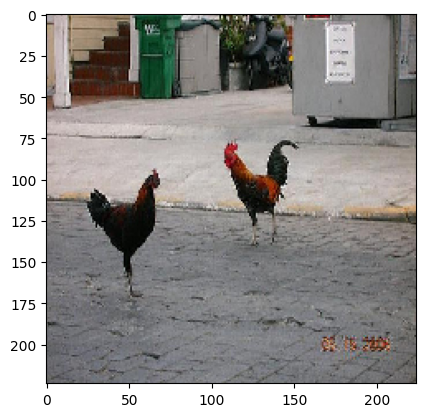

In [9]:
img = keras.utils.load_img("data/images/bird/n01514668_7481.JPEG", target_size=IMAGE_SIZE)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% bird and {100 * score:.2f}% dog.")